Example from scikit downscale

In [1]:
# modules
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

time_slice = slice('1990-01-01', '1990-12-31')

from sklearn.model_selection import train_test_split
from utils import get_sample_data

In [2]:
# function to plot

In [3]:
# utilities for plotting cdfs
def plot_cdf(ax=None, **kwargs):
    if ax:
        plt.sca(ax)
    else:
        ax = plt.gca()

    for label, X in kwargs.items():
        vals = np.sort(X, axis=0)
        pp = scipy.stats.mstats.plotting_positions(vals)
        ax.plot(pp, vals, label=label)
    ax.legend()
    return ax


def plot_cdf_by_month(ax=None, **kwargs):
    fig, axes = plt.subplots(4, 3, sharex=True, sharey=False, figsize=(12, 8))

    for label, X in kwargs.items():
        for month, ax in zip(range(1, 13), axes.flat):

            vals = np.sort(X[X.index.month == month], axis=0)
            pp = scipy.stats.mstats.plotting_positions(vals)
            ax.plot(pp, vals, label=label)
            ax.set_title(month)
    ax.legend()
    return ax

https://github.com/pangeo-data/scikit-downscale/blob/main/examples/2020ECAHM-scikit-downscale.ipynb

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import pandas as pd
import scipy
import xarray as xr
import os
import os.path

import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# load data

In [6]:
from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6
from Functions_ImportData import import_treat_obs_NOAA
from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6_close_to_stationNOAA
from Bias_correction_function import BC
from Bias_correction_function import treat_data_for_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
data_obs_NOAA=import_treat_obs_NOAA()
climate_var_NEX_GDDP_CMIP6_EmplacementStation=import_treat_modeled_NEX_GDDP_CMIP6_close_to_stationNOAA('tas', 'Celsius')
df_tas = treat_data_for_test(data_obs_NOAA,'TAVG',climate_var_NEX_GDDP_CMIP6_EmplacementStation,'Daily Near-Surface Air Temperature °C','BEIRA, MZ','ACCESS-CM2')

KeyError: 'pcp'

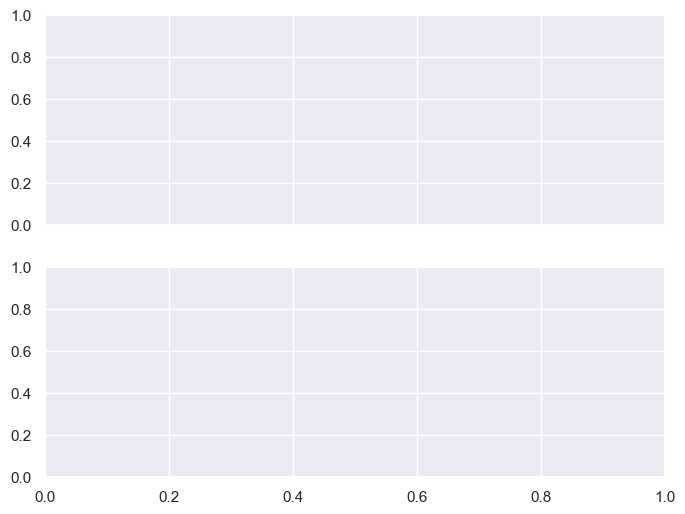

In [8]:
# load sample data
r'''
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
# extract 1 point of training data for precipitation and temperature
df = (
    data.isel(point=0)
    .to_dataframe()[['T2max', 'PREC_TOT']]
    .rename(columns={'T2max': 'tmax', 'PREC_TOT': 'pcp'})
)
df['tmax'] -= 273.13
df['pcp'] *= 24
training= df.resample('1d').first()
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='targets')
        # extract 1 point of training data for precipitation and temperature
targets =data.isel(point=0).to_dataframe()[['Tmax', 'Prec']].rename(columns={'Tmax': 'tmax', 'Prec': 'pcp'})


# print a table of the training/targets data
display(pd.concat({'training': training, 'targets': targets}, axis=1))
'''
training=df_tas['training']
targets=df_tas['targets']
# make a plot of the temperature and precipitation data
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 6), sharex=True)
time_slice = slice('1990-01-01', '1990-12-31')

# plot-temperature
training[time_slice]['pcp'].plot(ax=axes[0], label='training')
targets[time_slice]['pcp'].plot(ax=axes[0], label='targets')
axes[0].legend()
axes[0].set_ylabel('Precipitation [mm/day]')

# plot-precipitation
training[time_slice]['pcp'].plot(ax=axes[1])
targets[time_slice]['pcp'].plot(ax=axes[1])
_ = axes[1].set_ylabel('Precipitation [mm/day]')

In [ ]:
# exploratory data analysis for arrm model

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from mlinsights.mlmodel import PiecewiseRegressor

def ARRM(n_bins=7):
    return Pipeline([
        ('')
    ])


sns.set(style='whitegrid')
c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

qqwargs = {'n_quantiles': 1e6, 'copy': True, 'subsample': 1e6}
n_bins = 7

X = training[['tmax']]['1980': '2000'].values
y = targets[['tmax']]['1980': '2000'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
y_train = y_train[:, 0]
for strat in ['kmeans', 'uniform', 'quantile']:
    model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy=strat))

    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(strat, model.score(X_test, y_test))
    
model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='kmeans'))
model.fit(X_train, y_train)
pred = model.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.scatter(X_train, y_train, c=c['train'], s=5, label='train')
plt.scatter(X_test, y_test, c=c['test'], s=5, label='test')
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.scatter(np.sort(X_train, axis=0), np.sort(y_train, axis=0), c=c['train'], s=5, label='train')
plt.scatter(np.sort(X_test, axis=0), np.sort(y_test, axis=0), c=c['test'], s=5, label='test')
plt.plot(np.sort(X_test, axis=0), np.sort(pred, axis=0), c=c['predict'], lw=2, label='predictions')
ax.legend()

# fig, ax = plt.subplots(1, 1)
# ax.plot(Xq_test[:, 0], yq_test, ".", label='data', c=c['test'])
# ax.plot(Xq_test[:, 0], predq, ".", label="predictions", c=c['predict'])
# ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
# ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(X_test[:, 0], y_test, ".", label='data', c=c['test'])
ax.plot(X_test[:, 0], pred, ".", label="predictions", c=c['predict'])
ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
ax.legend()

https://github.com/pangeo-data/scikit-downscale/blob/main/examples/bcsd_example.ipynb

In [ ]:
# open a small dataset for training
training = xr.open_zarr("../data/downscale_test_data.zarr.zip", group="training")
training

In [ ]:
# open a small dataset of observations (targets)
targets = xr.open_zarr("../data/downscale_test_data.zarr.zip", group="targets")
targets

In [ ]:
# extract 1 point of training data for precipitation and temperature
X_temp = training.isel(point=0).to_dataframe()[["T2max"]].resample("MS").mean() - 273.13
X_pcp = training.isel(point=0).to_dataframe()[["PREC_TOT"]].resample("MS").sum() * 24
display(X_temp.head(), X_pcp.head())

In [ ]:
# extract 1 point of target data for precipitation and temperature
y_temp = targets.isel(point=0).to_dataframe()[["Tmax"]].resample("MS").mean()
y_pcp = targets.isel(point=0).to_dataframe()[["Prec"]].resample("MS").sum()
display(y_temp.head(), y_pcp.head())

In [ ]:
# Fit/predict the BCSD Precipitation model
from skdownscale.pointwise_models import BcsdPrecipitation
bcsd_pcp = BcsdPrecipitation()
bcsd_pcp.fit(X_pcp.loc['1979':'2013'], y_pcp.loc['1979':'2013'])
out = bcsd_pcp.predict(X_pcp.loc['1979':'2013']) * X_pcp.loc['1979':'2013']
plot_cdf(X=X_pcp.loc['1979':'2013'], y=y_pcp.loc['1979':'2013'], out=out)
plot_cdf_by_month(X=X_pcp, y=y_pcp, out=out)

In [ ]:
# Fit/predict the BCSD Precipitation model
from skdownscale.pointwise_models import BcsdTemperature
bcsd_temp = BcsdTemperature()
bcsd_temp.fit(X_temp.loc['1979':'2013'], y_temp.loc['1979':'2013'])
out = bcsd_temp.predict(X_temp.loc['1979':'2013']) * X_temp.loc['1979':'2013']
plot_cdf(X=X_temp.loc['1979':'2013'], y=y_temp.loc['1979':'2013'], out=out)
plot_cdf_by_month(X=X_pcp, y=y_pcp, out=out)

## 2.2 Models as cattle, not pets

https://github.com/earthcube2020/ec20_hamman_etal/blob/master/2020ECAHM-scikit-downscale.ipynb

In [ ]:
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
# load sample data
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
# extract 1 point of training data for precipitation and temperature
df = (
    data.isel(point=0)
    .to_dataframe()[['T2max', 'PREC_TOT']]
    .rename(columns={'T2max': 'tmax', 'PREC_TOT': 'pcp'})
)
df['tmax'] -= 273.13
df['pcp'] *= 24
training= df.resample('1d').first()
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='targets')
        # extract 1 point of training data for precipitation and temperature
targets =data.isel(point=0).to_dataframe()[['Tmax', 'Prec']].rename(columns={'Tmax': 'tmax', 'Prec': 'pcp'})


In [ ]:
def ARRM(n_bins=7):
    return Pipeline([
        ('')
    ])


sns.set(style='whitegrid')
c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

qqwargs = {'n_quantiles': 1e6, 'copy': True, 'subsample': 1e6}
n_bins = 7

In [ ]:
X = training[['tmax']]['1980': '2000'].values
y = targets[['tmax']]['1980': '2000'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
y_train = y_train[:, 0]
    
model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='kmeans'))
#print(strat, model.score(X_test, y_test))
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation


models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0)
}

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')

In [ ]:
# extract training / prediction data
X_train = training[['tmax']][train_slice]
y_train = targets[['tmax']][train_slice]
X_predict = training[['tmax']][predict_slice]

# Fit all models
for key, model in models.items():
    model.fit(X_train, y_train)

In [ ]:
# store predicted results in this dataframe
predict_df = pd.DataFrame(index = X_predict.index)

for key, model in models.items():
    print('key')
    print(key)
    print('model')
    print(model)
    print(model.predict(X_predict))
    if type(model.predict(X_predict))==pd.core.frame.DataFrame:
        if len(list(model.predict(X_predict).columns))>1:
            predict_df[key] = model.predict(X_predict)[['pred']].values # [['pred']] added to deal with piecewise regressor
        else:
            predict_df[key] = model.predict(X_predict)
    else:
        predict_df[key] = model.predict(X_predict) # [['pred']] added to deal with piecewise regressor

# show a table of the predicted data
display(predict_df.head())

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3.5))
targets['tmax'][time_slice].plot(ax=ax, label='target', c='k', lw=1, alpha=0.75, legend=True, zorder=10)
X_predict['tmax'][time_slice].plot(label='original', c='grey', ax=ax, alpha=0.75, legend=True)
predict_df[time_slice].plot(ax=ax, lw=0.75)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_ylabel('Temperature [C]')

In [ ]:
# calculate r2
score = (predict_df.corrwith(targets.tmax[predict_slice]) **2).sort_values().to_frame('r2_score')
display(score)

In [ ]:
from utils import prob_plots

fig = prob_plots(X_predict, targets['tmax'], predict_df[score.index.values], shape=(3, 3), figsize=(12, 12))


## Zscore

Z-Score bias correction is a good technique for target variables with Gaussian probability distributions, such as zonal wind speed.

In [ ]:
from skdownscale.pointwise_models import ZScoreRegressor

In [ ]:
# load sample data
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
# extract 1 point of training data for precipitation and temperature
df = (
    data.isel(point=0)
    .to_dataframe()[['T2max', 'PREC_TOT']]
    .rename(columns={'T2max': 'tmax', 'PREC_TOT': 'pcp'})
)
df['tmax'] -= 273.13
df['pcp'] *= 24
training= df.resample('1d').first()
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='targets')
        # extract 1 point of training data for precipitation and temperature
targets =data.isel(point=0).to_dataframe()[['Tmax', 'Prec']].rename(columns={'Tmax': 'tmax', 'Prec': 'pcp'})


In [ ]:
Trainings = training[['tmax']][train_slice]
target = targets[['tmax']][train_slice]
future = training[['tmax']][predict_slice]

In [ ]:

# open a small dataset
training = get_sample_data('wind-hist')
target = get_sample_data('wind-obs')
future = get_sample_data('wind-rcp')

In [ ]:
# bias correction using ZScoreRegresssor
zscore = ZScoreRegressor()
zscore.fit(Trainings, target)
fit_stats = zscore.fit_stats_dict_
out = zscore.predict(future)
predict_stats = zscore.predict_stats_dict_

In [ ]:
# visualize the datasets
from utils import zscore_ds_plot

zscore_ds_plot(training, target, future, out)

In [ ]:
from utils import zscore_correction_plot

zscore_correction_plot(zscore)

## Automatic parallelization

In [ ]:
# parameters
train_slice = slice('1980', '1982')  # train time range
holdout_slice = slice('1990', '1991')  # prediction time range

# bounding box of downscaling region
lon_slice = slice(-124.8, -120.0) 
lat_slice = slice(50, 45)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [ ]:
from dask.distributed import Client

client = Client()
client

In [ ]:
import xarray as xr

fnames = [f'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/tmmx/tmmx_{year}.nc'
          for year in range(int(train_slice.start), int(train_slice.stop) + 1)]
# open the data and cleanup a bit of metadata
obs = xr.open_mfdataset(fnames, engine='pydap',combine='nested', concat_dim='day').rename({'day': 'time'}).drop('crs')

obs_subset = obs['air_temperature'].sel(time=train_slice, lon=lon_slice, lat=lat_slice).resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# display
display(obs_subset)
obs_subset.isel(time=0).plot()

# Add models to list to test

In [9]:
from mlinsights.mlmodel import QuantileLinearRegression
from mlinsights.mlmodel import PiecewiseRegressor
from mlinsights.mlmodel import QuantileMLPRegressor
from sklearn.preprocessing import KBinsDiscretizer

In [10]:
def ARRM(n_bins=7):
    return Pipeline([
        ('')
    ])


sns.set(style='whitegrid')
c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

qqwargs = {'n_quantiles': 1e6, 'copy': True, 'subsample': 1e6}
n_bins = 7

In [11]:
X = training[['temp']]['1980': '2000'].values
y = targets[['temp']]['1980': '2000'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation


models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0),
    'Sklearn: QuantileMLPRegressor': QuantileMLPRegressor(),
    'Sklearn: QuantileLinearRegression': QuantileLinearRegression(),
    #'Sklearn: PiecewiseRegressor': PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='kmeans'))
    
}

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')

In [17]:
# extract training / prediction data
X_train = training[['temp']][train_slice]
y_train = targets[['temp']][train_slice]
X_predict = training[['temp']][predict_slice]

# Fit all models
for key, model in models.items():
    print(model)
    if 'PiecewiseRegressor' in key: # does't work
        model.fit(X_train.values.reshape((len(X_train),1)), y_train.values.reshape((len(y_train),)))
    if 'QuantileLinearRegression' in key:
        model.fit(X_train.values.reshape((len(X_train.values),1)), y_train.values.reshape((len(y_train.values),)))
    else:
        model.fit(X_train.values.reshape((len(X_train),1)), y_train.values.reshape((len(y_train),)))

PureAnalog(n_analogs=1)
PureAnalog(kind='sample_analogs', n_analogs=10)
PureAnalog(kind='weight_analogs', n_analogs=10)
PureAnalog(kind='weight_analogs', n_analogs=100)
PureAnalog(kind='mean_analogs', n_analogs=10)
AnalogRegression(n_analogs=100)
LinearRegression()
BcsdTemperature(return_anoms=False)
RandomForestRegressor(random_state=0)
QuantileMLPRegressor()
QuantileLinearRegression()


In [28]:
# store predicted results in this dataframe
predict_df = pd.DataFrame(index = X_predict.index)

for key, model in models.items():
    print('key')
    print(key)
    print('model')
    print(model)
    if 'PiecewiseRegressor' in key: # does't work
        predict_df[key] = model.predict(X_predict)
    try:
        if type(model.predict(X_predict))==pd.core.frame.DataFrame:
            if len(list(model.predict(X_predict).columns))>1:
                predict_df[key] = model.predict(X_predict)[['pred']].values # [['pred']] added to deal with piecewise regressor
            else:
                predict_df[key] = model.predict(X_predict)
    except:
        pass
    else:
        try:
            if len(list(model.predict(X_predict).columns))>1:
                predict_df[key] = model.predict(X_predict)[['pred']].values # [['pred']] added to deal with piecewise regressor
            else:
                predict_df[key] = model.predict(X_predict)
        except:
            predict_df[key] = model.predict(X_predict)

# show a table of the predicted data
display(predict_df.head())

key
GARD: PureAnalog-best-1
model
PureAnalog(n_analogs=1)
key
GARD: PureAnalog-sample-10
model
PureAnalog(kind='sample_analogs', n_analogs=10)
key
GARD: PureAnalog-weight-10
model
PureAnalog(kind='weight_analogs', n_analogs=10)
key
GARD: PureAnalog-weight-100
model
PureAnalog(kind='weight_analogs', n_analogs=100)
key
GARD: PureAnalog-mean-10
model
PureAnalog(kind='mean_analogs', n_analogs=10)
key
GARD: AnalogRegression-100
model
AnalogRegression(n_analogs=100)
key
GARD: LinearRegression
model
LinearRegression()
key
BCSD: BcsdTemperature
model
BcsdTemperature(return_anoms=False)
key
Sklearn: RandomForestRegressor
model
RandomForestRegressor(random_state=0)
key
Sklearn: QuantileMLPRegressor
model
QuantileMLPRegressor()
key
Sklearn: QuantileLinearRegression
model
QuantileLinearRegression()


,GARD: PureAnalog-best-1,GARD: PureAnalog-sample-10,GARD: PureAnalog-weight-10,GARD: PureAnalog-weight-100,GARD: PureAnalog-mean-10,GARD: AnalogRegression-100,GARD: LinearRegression,Sklearn: RandomForestRegressor,Sklearn: QuantileMLPRegressor,Sklearn: QuantileLinearRegression
time,,,,,,,,,,
1990-01-01,26.2,27.2,26.738325,27.003207,26.92,27.369752,27.289867,26.415,27.423088,27.350237
1990-01-02,29.5,28.9,28.357810,27.370110,27.96,27.003886,27.081829,29.208,27.197206,27.139679
1990-01-03,27.8,27.6,27.302280,27.227172,26.65,27.028368,26.847226,27.724,26.942480,26.902233
1990-01-04,29.4,27.0,27.512352,27.516749,27.32,27.656210,27.525222,27.633,27.678630,27.588444
1990-01-05,30.2,23.3,27.390799,27.646219,27.33,27.857988,28.943271,28.827,29.218309,29.023672


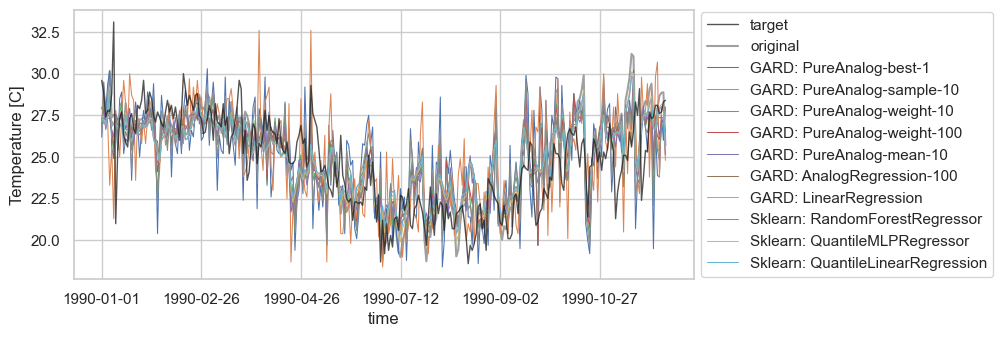

In [29]:
fig, ax = plt.subplots(figsize=(8, 3.5))
targets['temp'][time_slice].plot(ax=ax, label='target', c='k', lw=1, alpha=0.75, legend=True, zorder=10)
X_predict['temp'][time_slice].plot(label='original', c='grey', ax=ax, alpha=0.75, legend=True)
predict_df[time_slice].plot(ax=ax, lw=0.75)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_ylabel('Temperature [C]')

In [30]:
# calculate r2
score = (predict_df.corrwith(targets.temp[predict_slice]) **2).sort_values().to_frame('r2_score')
display(score)

,r2_score
GARD: PureAnalog-best-1,0.296680
GARD: PureAnalog-sample-10,0.313349
Sklearn: RandomForestRegressor,0.404111
GARD: PureAnalog-weight-10,0.454382
GARD: PureAnalog-weight-100,0.500057
GARD: PureAnalog-mean-10,0.521778
Sklearn: QuantileMLPRegressor,0.543217
GARD: LinearRegression,0.543217
Sklearn: QuantileLinearRegression,0.543217
GARD: AnalogRegression-100,0.561287


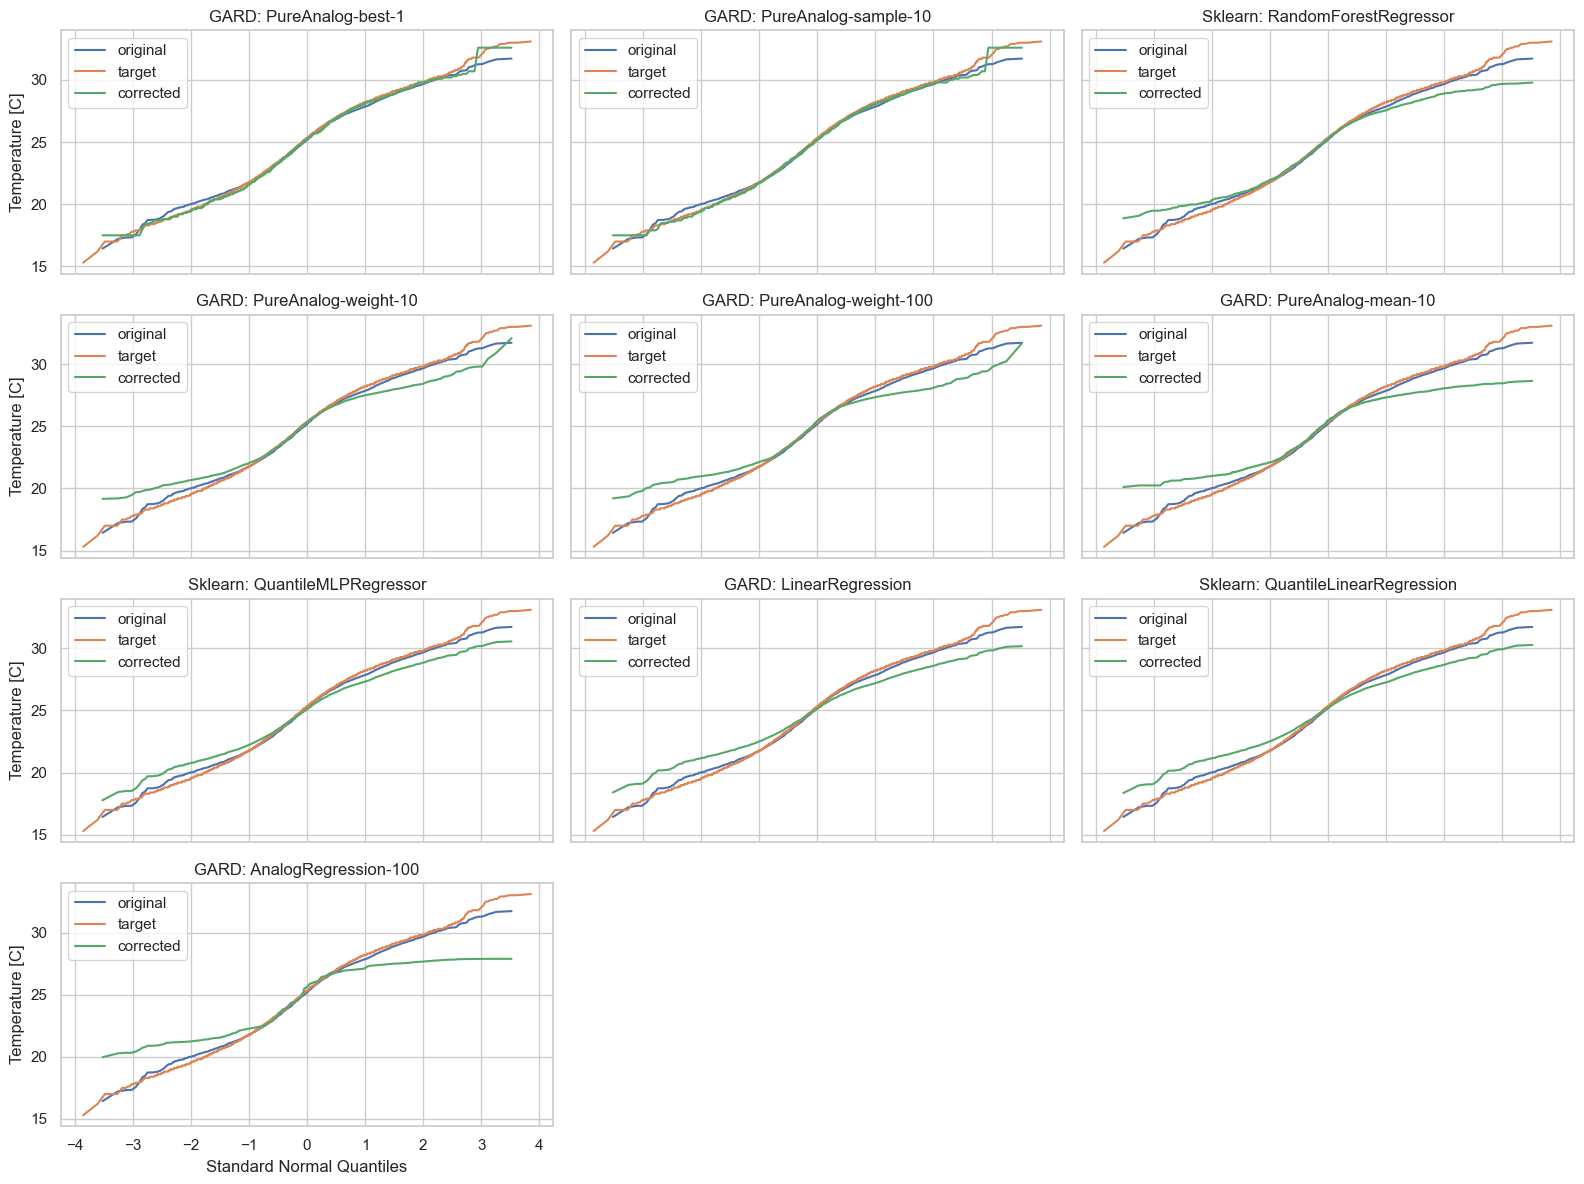

In [31]:
from utils import prob_plots

fig = prob_plots(X_predict, targets['temp'], predict_df[score.index.values], shape=(4, 3), figsize=(16, 12))
